In [194]:
import torch
from torch import nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from botorch.models.gpytorch import GPyTorchModel
from botorch.models import ModelListGP
from botorch.fit import fit_gpytorch_mll, fit_gpytorch_mll_torch
from botorch.acquisition.multi_objective import qLogExpectedHypervolumeImprovement
from botorch.utils.multi_objective.box_decompositions import FastNondominatedPartitioning
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective import is_non_dominated
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import SumMarginalLogLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, ConstantKernel
from gpytorch.constraints import Interval
from gpytorch.models import ExactGP
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from botorch.test_functions import BraninCurrin, ZDT3
from botorch.utils import draw_sobol_samples
from sklearn.preprocessing import StandardScaler

In [222]:
class FeatureExtractor(nn.Sequential):
    def __init__(self, input_dim, hidden_dim=32, n_hidden=1, output_dim=None):
        super().__init__()
        if output_dim is None: output_dim = input_dim
        self.output_dim = output_dim
        fc1 = nn.Linear(input_dim, hidden_dim)
        nn.init.kaiming_normal_(fc1.weight, nonlinearity='tanh')
        nn.init.zeros_(fc1.bias)
        self.add_module("fc1", fc1)
        self.add_module("tanh", nn.Tanh())

        for i in range(n_hidden):
            dense = nn.Linear(hidden_dim, hidden_dim)
            nn.init.kaiming_normal_(dense.weight, nonlinearity='tanh')
            nn.init.zeros_(dense.bias)
            self.add_module("dense" + str(i), dense)
            self.add_module("tanh", nn.Tanh())

        fc2 = nn.Linear(hidden_dim, output_dim)
        nn.init.kaiming_normal_(fc2.weight, nonlinearity='tanh')
        nn.init.zeros_(fc2.bias)
        self.add_module("fc2", fc2)


class DKLGP(ExactGP, GPyTorchModel):
    _num_outputs = 2
    def __init__(self, train_x, train_y, feature_extractor, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.feature_extractor = feature_extractor
        self.likelihood = likelihood

        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=self.feature_extractor.output_dim, lengthscale_constraint=Interval(1e-3, 1e3, initial_value=torch.ones(self.feature_extractor.output_dim, dtype=torch.float64))))# + ConstantKernel()

    def forward(self, x):
        x = self.feature_extractor(x)  # NOTE: try commenting out this line for a normal GP and leave it uncommented for deep kernel learning
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


problem = BraninCurrin(0.0, negate=True)
# problem = ZDT3(dim=2, num_objectives=2, noise_std=0.0, negate=True)


torch.manual_seed(1)
device = torch.device("cpu")

# Initial data
train_x = draw_sobol_samples(problem.bounds, 10, 1).squeeze(1).to(torch.float64)
train_y = problem(train_x)
transformer = StandardScaler()
train_y = torch.tensor(transformer.fit_transform(train_y))

# Model
models = []
for i in range(train_y.size(1)):
    feature = DKLGP(train_x, train_y[:, i], FeatureExtractor(input_dim=2, hidden_dim=8, n_hidden=1, output_dim=None).to(torch.float64), GaussianLikelihood().to(torch.float64)).to(torch.float64)
    models.append(feature)
model = ModelListGP(*models).to(torch.float64)
mll = SumMarginalLogLikelihood(model.likelihood, model)
model.train()
try:
    raise RuntimeError()
    fit_gpytorch_mll(mll)
except:
    optimizer = Adam(model.parameters(), lr=0.01)
    fit_gpytorch_mll_torch(mll, optimizer=optimizer)  # NOTE: Always use torch optimizers as they seem to be more stable

# BO loop
for i in range(50):
    ref_point = train_y.min(dim=0).values
    partitioning = FastNondominatedPartitioning(ref_point=ref_point, Y=train_y)
    EI = qLogExpectedHypervolumeImprovement(model=model, ref_point=ref_point, partitioning=partitioning)

    candidate, _ = optimize_acqf(EI, bounds=problem.bounds, q=1, num_restarts=5, raw_samples=20)

    # Update data and fit the transformer again
    train_x = torch.cat([train_x, candidate])
    train_y = torch.tensor(transformer.fit_transform(problem(train_x)))

    # Refit model
    model.models[0].set_train_data(train_x, train_y[:, 0], strict=False)
    model.models[1].set_train_data(train_x, train_y[:, 1], strict=False)
    model.train()
    try:
        raise RuntimeError()
        fit_gpytorch_mll(mll)
    except:
        # print("Scipy failed to fit the model, reverting to a torch optimizer")
        optimizer = Adam(model.parameters(), lr=0.01)
        fit_gpytorch_mll_torch(mll, optimizer=optimizer)  # NOTE: Always use torch optimizers as they seem to be more stable

    print(f"Iter {i + 1}: Latest value = {train_y[-1, :].tolist()} - Candidate: {candidate}")


Iter 1: Latest value = [0.6248011164057046, 1.9899174380107547] - Candidate: tensor([[0., 1.]], dtype=torch.float64)
Iter 2: Latest value = [0.29727308109366424, -0.10295518027910963] - Candidate: tensor([[0.6779, 0.3867]], dtype=torch.float64)
Iter 3: Latest value = [-0.1988586952307669, 0.2981110375516683] - Candidate: tensor([[0.7038, 0.5253]], dtype=torch.float64)
Iter 4: Latest value = [-2.8665941889326687, 1.3565163789991503] - Candidate: tensor([[0., 0.]], dtype=torch.float64)
Iter 5: Latest value = [-2.041075709830814, 1.236971942057255] - Candidate: tensor([[0.0000, 0.0570]], dtype=torch.float64)
Iter 6: Latest value = [-0.3741811184492335, 0.5878161862608013] - Candidate: tensor([[0.3897, 1.0000]], dtype=torch.float64)
Iter 7: Latest value = [-0.6972998001743926, 1.3351344099371405] - Candidate: tensor([[0.0000, 0.3519]], dtype=torch.float64)
Iter 8: Latest value = [0.053068917275014574, 0.18923358773001575] - Candidate: tensor([[0.6933, 0.6343]], dtype=torch.float64)
Iter 9:

In [223]:
n_points = 500
x1 = torch.linspace(0, 1, n_points)
x2 = torch.linspace(0, 1, n_points)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')
X = torch.stack([X1.flatten(), X2.flatten()], dim=-1).double()

old_noise = problem.noise_std
problem.noise_std = 0.0  # make pareto fron predictions with zero noise
Y = problem(X)
problem.noise_std = old_noise

pareto_mask = is_non_dominated(Y)
pareto_front = Y[pareto_mask]
pareto_front_X = X[pareto_mask]

[]

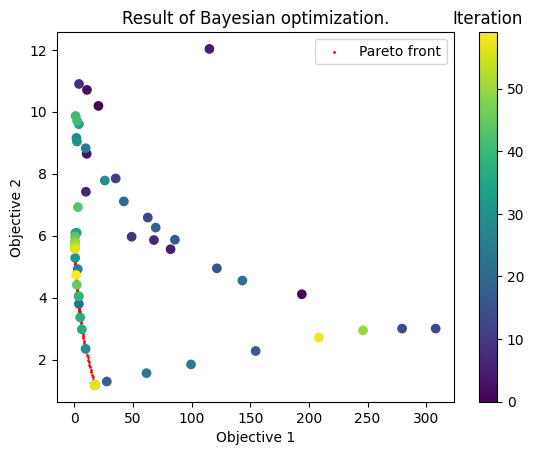

In [224]:
y = transformer.inverse_transform(train_y)
color = torch.arange(0, len(train_y), 1)
plt.scatter(-pareto_front[:, 0], -pareto_front[:, 1], alpha=1, color='red', s=1, label="Pareto front")
plt.scatter(-y[:, 0], -y[:, 1], c=color)
cbar = plt.colorbar()
cbar.ax.set_title("Iteration")
plt.legend()
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.title("Result of Bayesian optimization.")
plt.plot()

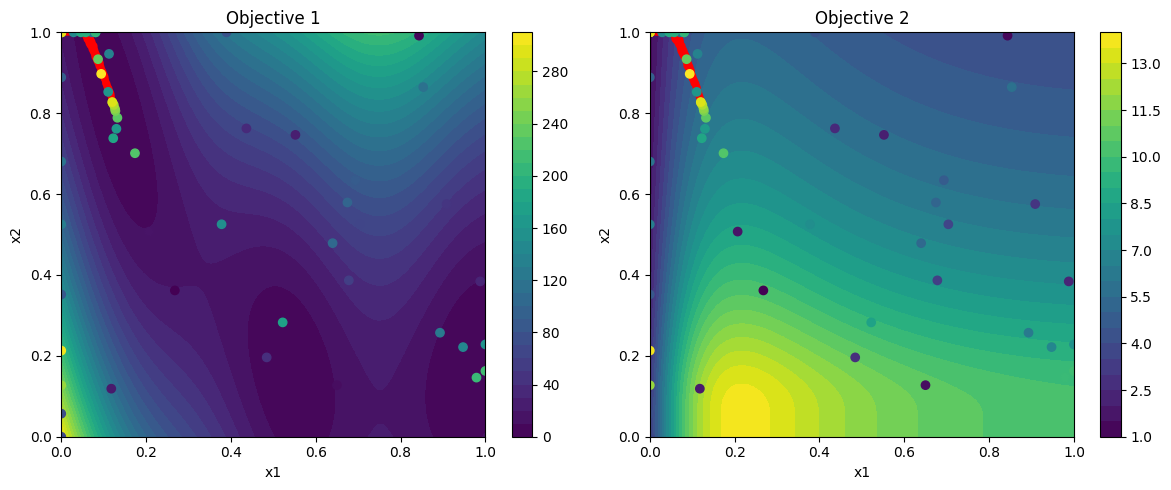

In [225]:
# Create a grid in the input space
N = 100
x1 = torch.linspace(problem.bounds[0, 0], problem.bounds[1, 0], N)
x2 = torch.linspace(problem.bounds[0, 1], problem.bounds[1, 1], N)
X1, X2 = torch.meshgrid(x1, x2, indexing='ij')

# Flatten and evaluate
X = torch.stack([X1.reshape(-1), X2.reshape(-1)], dim=-1)
Y = problem(X).detach()

Z1 = -Y[:, 0].reshape(N, N)
Z2 = -Y[:, 1].reshape(N, N)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

cs1 = axs[0].contourf(X1.numpy(), X2.numpy(), Z1.numpy(), levels=30, cmap='viridis')
axs[0].scatter(pareto_front_X[:, 0], pareto_front_X[:, 1], c='red', s=10, label='Pareto-optimal inputs')
axs[0].scatter(train_x[:, 0], train_x[:, 1], c=color, label="Sampled points")
axs[0].set_title("Objective 1")
axs[0].set_xlabel("x1")
axs[0].set_ylabel("x2")
fig.colorbar(cs1, ax=axs[0])

cs2 = axs[1].contourf(X1.numpy(), X2.numpy(), Z2.numpy(), levels=30, cmap='viridis')
axs[1].scatter(pareto_front_X[:, 0], pareto_front_X[:, 1], c='red', s=10, label='Pareto-optimal inputs')
axs[1].scatter(train_x[:, 0], train_x[:, 1], c=color, label="Sampled points")
axs[1].set_title("Objective 2")
axs[1].set_xlabel("x1")
axs[1].set_ylabel("x2")
fig.colorbar(cs2, ax=axs[1])

plt.tight_layout()
plt.show()